# Pytorch Lightning

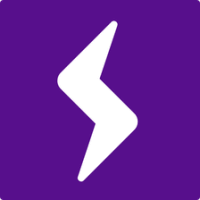

Let's start again by installing pytorch lightning.

In [1]:
!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl
print(f"Lightning version: {pl.__version__}")
if not pl.__version__.startswith("0.7.6"):
    print("You are using another version of pytorch lightning. We expect pytorch lightning 0.7.6. You can continue with your version but it"
          " might cause some issues")

Lightning version: 0.7.6


## Motivation

Writing code for deep learning models is not always exciting. Between different models there exist large overlaps, such as the solver, that need to be adapted for each project. Additionally, organizational methods such as logging hyperparameters that have been used for an experiment or logging the training and validation loss don't change from one project to the next. However, in the beginning it may be hard and time-consuming to find the best method for that. In this notebook, we propose a method that provides a nice solution for these problems, the framework PyTorch Lightning, based on PyTorch.


### Idea behind PyTorch Lightning
Following our observations, we can classify deep learning code into three categories
* Research code (the exciting part!, changes with new tasks, models etc.) $\rightarrow$ into new LightningModule
* Engineering code (the same for all projects and models) $\rightarrow$ Trainer class
* Non-essential code (logging, organizing runs – very important, but should be automated) $\rightarrow$ Callbacks 

PyTorch Lightning introduces three solutions for these categories, the LightningModule, a Trainer and Callbacks. 

1. **LightningModules** contain all model related code. This is the part where we are working on when creating a new project. The idea is to have all important code in one module, e.g., the model's architecture and the evalutation of training and validation metrics. This provides a better overview as repeated elements, such as the training procedure, are not stored in the code that we work on. The lightning module also handles the calls `.to(device)` or `.train()` and `.eval()`. Hence, there is no need anymore to switch between the cpu and gpu and to take care of the model's mode as this is automated by the LightningModule. The framework also enables easy parallel computation on multiple gpus. 

2. **Trainer** contains all code needed for training our neural networks that doesn't change for each project ("one size fits all"). Usually, we don't touch the code automated by this class. The arguments that are specific for one training such as learning rate and batch size are provided as initialization arguments for the LightningModule.

3. **Callbacks** automate all parts needed for logging hyperparameters or training results such as the tensorboard logger. Logging becomes very important for research later since the results of experiments need to be reproducible.

All in all, PyTorch is a framework that handles all (annoying) "engeneering" stuff for you such that you have more time for exciting research and scientific coding. This also results in the advantage that automated parts are guaranteed to be bug-free. Hence, you can't include a bug in a part of your code that is often used but not often checked. PyTorch Lightning is very young (it only started last summer) with an active developping community. There are lots of features to come and if you're missing a feature, often, the solution will be added within some days after opening an issue on github.

## Introduction

Research relevant code goes into the LightningModule:
advantage: also training & validation steps are in this module as they change from task to task or model to model

![alt text](https://github.com/PyTorchLightning/pytorch-lightning/raw/master/docs/source/_images/lightning_module/pt_to_pl.png)

The remaining code is automated in the Trainer class 

![alt text](https://github.com/PyTorchLightning/pytorch-lightning/raw/master/docs/source/_images/lightning_module/pt_trainer.png)

## Get Startet With PyTorch Lightning

### 1. Define A LightningModule

We define our network as an instance of `pl.LightningModule` which replaces your old network based on the class `nn.Module`. Additionally, it contains all relevant parts that are used for training and evaluating different models on various tasks.

Forward pass and `__init__()` remain the same, we can just copy the code from the `nn.Module`.

```python
class TwoLayerNet(pl.LightningModule):
    def __init__(self, hparams, input_size=1 * 28 * 28, hidden_size=512, num_classes=10):
        super().__init__()
        self.hparams = hparams

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        # flatten the image first
        N, _, _, _ = x.shape
        x = x.view(N, -1)

        x = self.model(x)

        return x 
```

Training steps and validation steps also change with different tasks, losses, or evaluation metrics. Consequently, it is useful to integrate these parts in the model. Validation loss is logged for each validation iteration and aggregated at the end of the epoch.

```python
    def training_step(self, batch, batch_idx):
        images, targets = batch

        # forward pass
        out = self.forward(images)

        # loss
        loss = F.cross_entropy(out, targets)

        # accuracy
        _, preds = torch.max(out, 1)  # convert output probabilities to predicted class
        acc = preds.eq(targets).sum() / targets.size(0)

        # logs
        tensorboard_logs = {'loss': loss, 'acc': acc}

        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, targets = batch

        # forward pass
        out = self.forward(images)

        # loss
        loss = F.cross_entropy(out, targets)

        # accuracy
        _, preds = torch.max(out, 1)
        acc = preds.eq(targets).sum() / targets.size(0)

        if batch_idx == 0:
            self.visualize_predictions(images, out.detach(), targets)

        return {'val_loss': loss, 'val_acc': acc}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}

        return {'val_loss': avg_loss, 'log': tensorboard_logs}

```

We can also integrate the data loader into our model. For that, we first define our datasets in the method `prepare_data()` that is called after the initialization of the LightningModule. Afterward, we can call the datasets in the methods `train_dataloader()`and `val_dataloader()`

```python
    def prepare_data(self):
        # download
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])

        fashion_mnist_train = torchvision.datasets.FashionMNIST(root='../datasets', train=True,
                                                                  download=True, transform=transform)

        fashion_mnist_test = torchvision.datasets.FashionMNIST(root='../datasets', train=False,
                                                                  download=True, transform=transform)

        # train/val split
        torch.manual_seed(0)
        train_dataset, val_dataset = random_split(fashion_mnist_train, [50000, 10000])
        torch.manual_seed(torch.initial_seed())

        # assign to use in dataloaders
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = fashion_mnist_test

    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle=True, batch_size=self.hparams["batch_size"])

    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams["batch_size"])
```

The last step that is missing in our LightningModule is the optimizer. This method needs to be defined in every LightningModule (together with init, forward, training_step, training_dataloader)

```python
    def configure_optimizers(self):
        optim = torch.optim.SGD(self.model.parameters(), self.hparams["learning_rate"], momentum=0.9)

        return optim
```

Note that the code samples of all these steps existed before. Lightning just rearranges them and stores the important parts in a new module. The remaining code is automated in the Training class:

###  2. Fit the model with a Trainer

We initialize the model with a set of hyperparameters given in the dictionary `hparams`. 

<div class="alert alert-block alert-info">
**Remark:** Set the option `weights_summary=None` to avoid that a summary of the weights is printed at the start of each training
</div>

In [2]:
from exercise_code.lightning_models import TwoLayerNet

hparams = {
    "batch_size": 16,
    "learning_rate": 1e-3,
}

model = TwoLayerNet(hparams)

trainer = pl.Trainer(
    # weights_summary=None,
    max_epochs=2,
)

trainer.fit(model)


GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/home/yuxuan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name    | Type       | Params
-----------------------------------
0 | model   | Sequential | 407 K 
1 | model.0 | Linear     | 401 K 
2 | model.1 | Sigmoid    | 0     
3 | model.2 | Linear     | 5 K   
/home/yuxuan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/yuxuan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

Checkout the directory `./lightning_logs`. For each run there is a new directory version_xx. The most right argument in the tqdm bar above shows the version of the current run. Each directory automatically contains a folder with checkpoints, tensorboard logs and the hyperparameters for this run.

As seen in the last notebook, you can have a look at the tensorboard logs of the runs with the command (in your terminal, opened at folder exercise_07)
```
tensorboard --logdir lightning_logs
```

## Add images to tensorboard

The tensorboard logger is a submodule of the LightningModule and can be accessed via `self.logger`. We can simply add images or anything else to the logging module by calling for example
```python
self.logger.experiment.add_image('tag', image)
```
to add an image. In the following we log the first batch of validation images in a grid together with the predicted class labels and the ground truth labels (in the second row). We add the lines
```python
        if batch_idx == 0:
            self.visualize_predictions(images, out.detach(), targets)
```
to the validation step that calls the following function:
```python
    def visualize_predictions(self, images, preds, targets):
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']

        # determine size of the grid based on given batch size
        num_rows = torch.tensor(len(images)).float().sqrt().floor()
        
        fig = plt.figure(figsize=(10, 10))
        for i in range(len(images)):
            plt.subplot(num_rows ,len(images) // num_rows + 1, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(class_names[torch.argmax(preds, axis=-1)[i]] + f'\n[{class_names[targets[i]]}]')
            plt.axis('off')

        self.logger.experiment.add_figure('predictions', fig, global_step=self.global_step)
```
You can view the logged images in your tensorboard under the tab "Images".

##  Features in PyTorch Lightning

The Trainer class contains some nice arguments, that make debugging in deep learning easier.

### Check your timings
The argument `profiler=True` measures the timings of dataloading, forward and backward pass for you. Run the cell below. After 3 epochs (`max_epochs=3`) the training stops and an overview of the timing is printed. This feature enables you to detect bottlenecks in your model. A bottleneck can be for example long times in dataloading. It becomes very important later, when you start to implement custom layers or loss functions.

In [3]:
trainer = pl.Trainer(
    weights_summary=None,
    profiler=True,
    max_epochs=2,
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.037534       	|  0.037534       
on_epoch_start      	|  0.003          	|  0.0059999      
get_train_batch     	|  0.0035113      	|  21.953         
on_batch_start      	|  2.2796e-05     	|  0.14247        
model_forward       	|  0.00081371     	|  5.0857         
model_backward      	|  0.0014863      	|  9.2896         
on_after_backward   	|  3.589e-06      	|  0.022431       
optimizer_step      	|  0.00084983     	|  5.3114         
on_batch_end        	|  0.0018373      	|  11.483         
on_epoch_end        	|  1.4519e-05     	|  2.9038e-05     
on_train_end        	|  0.0012562      	|  0.0012562      



1

### Debugging Options

There are many other debugging options provided with the Trainer class. A few useful one are
* `fast_dev_run=True`: Runs of batch of each train, val and test pass (if val and test are implemented). A fast way to check if everything works (dataloading, validation metric, model saving/ loading) without having to wait for a full epoch.
* `track_grad_norm=2`: Logs the l2-norm of the gradients (set to 1 for the l1-norm) for each layer in tensorboard. You can check wether the network is actually doing something. If the gradients are too small or too high, you won't have a good training (cf. vanishing/ exploding gradients)


### Other Features

Finally, we want to mention some other useful options in the Trainer class:
* `max_epochs`: Set the maximal number of epochs
* `weights_summary`: Prints a summary of the number of weights per layer at the beginning of the training. Set to None to avoid that.
* `resume_from_checkpoint`: Start the training from a checkpoint saved earlier. Argument is the path to the saved model file.
* `early_stop_callback`: Determine a metric to monitor for early stopping. The argument uses the callback class `EarlyStopping` that interrupts the training if the metric didn't improve for patience epochs. It can be applied as in the following code example 

```python
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
)

trainer = Trainer(early_stop_callback=early_stopping)
```

## Reference

1. Source code with a nice introduction https://github.com/PyTorchLightning/pytorch-lightning
2. Documentation, have a look at it, it's very well explained https://pytorch-lightning.readthedocs.io/en/stable/